# COVID-19 growth analysis

(c) 2020, [Thomas Wiecki](https://twitter.com/twiecki)

This notebook gets up-to-date data from the ["2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE"](https://systems.jhu.edu/research/public-health/ncov/) [GitHub repository](https://github.com/CSSEGISandData/COVID-19) and recreates the (pay-walled) plot in the [Financial Times]( https://www.ft.com/content/a26fbf7e-48f8-11ea-aeb3-955839e06441).

In [313]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
sns.set_context('talk')
plt.style.use('seaborn-whitegrid')

## Pull or update data

In [305]:
!if cd COVID-19; then git pull; else git clone https://github.com/CSSEGISandData/COVID-19.git COVID-19; fi

remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 64 (delta 31), reused 52 (delta 19), pack-reused 0
Unpacking objects: 100% (64/64), done.
From https://github.com/CSSEGISandData/COVID-19
   aa8295d..d73e80e  web-data   -> origin/web-data
Already up to date.


## Load data

In [306]:
def load_timeseries(name):
    df = pd.read_csv('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-{}.csv'.format(name), 
                     index_col=['Country/Region', 'Province/State', 'Lat', 'Long'], parse_dates=True)
    df['type'] = name.lower()
    df.columns.name = 'date'
    
    df = (df.set_index('type', append=True)
            .reset_index(['Lat', 'Long'], drop=True)
            .stack()
            .reset_index()
            .set_index('date')
         )
    df.index = pd.to_datetime(df.index)
    df.columns = ['country', 'state', 'type', 'cases']
    
    # Move HK to country level
    df.loc[(df.country == 'China') & (df.state =='Hong Kong'), 'country'] = 'Hong Kong'
    df.loc[(df.country == 'China') & (df.state =='Hong Kong'), 'state'] = np.nan
    
    # Aggregate large countries split by states
    df = pd.concat([df, df.loc[~df.state.isna()].groupby(['country', 'date', 'type']).sum().rename(index=lambda x: x+' (total)', level=0).reset_index(level=['country', 'type'])])
    return df

df = pd.concat([load_timeseries('Confirmed'),
           load_timeseries('Recovered'),
           load_timeseries('Deaths')])

In [307]:
df.head()

,country,state,type,cases
date,,,,
2020-01-22,Thailand,NaN,confirmed,2
2020-01-23,Thailand,NaN,confirmed,3
2020-01-24,Thailand,NaN,confirmed,5
2020-01-25,Thailand,NaN,confirmed,7
2020-01-26,Thailand,NaN,confirmed,8


In [348]:
# Country names seem to change quite a bit
df.country.unique()

array(['Thailand', 'Japan', 'Singapore', 'Nepal', 'Malaysia', 'Canada',
       'Australia', 'Cambodia', 'Sri Lanka', 'Germany', 'Finland',
       'United Arab Emirates', 'Philippines', 'India', 'Italy', 'Sweden',
       'Spain', 'Belgium', 'Egypt', 'Lebanon', 'Iraq', 'Oman',
       'Afghanistan', 'Bahrain', 'Kuwait', 'Algeria', 'Croatia',
       'Switzerland', 'Austria', 'Israel', 'Pakistan', 'Brazil',
       'Georgia', 'Greece', 'North Macedonia', 'Norway', 'Romania',
       'Estonia', 'Netherlands', 'San Marino', 'Belarus', 'Iceland',
       'Lithuania', 'Mexico', 'New Zealand', 'Nigeria', 'Ireland',
       'Luxembourg', 'Monaco', 'Qatar', 'Ecuador', 'Azerbaijan',
       'Armenia', 'Dominican Republic', 'Indonesia', 'Portugal',
       'Andorra', 'Latvia', 'Morocco', 'Saudi Arabia', 'Senegal',
       'Argentina', 'Chile', 'Jordan', 'Ukraine', 'Hungary',
       'Liechtenstein', 'Poland', 'Tunisia', 'Bosnia and Herzegovina',
       'Slovenia', 'South Africa', 'Bhutan', 'Cameroon', 'Colo

In [309]:
def plot_confirmed(countries, min_cases=100, ls='-'):
    for country in countries:
        (df.loc[(df.country == country) & (df.type == 'confirmed') & (df.cases >= min_cases)]
         .cases
         .reset_index()['cases']
         .plot(label=country, ls=ls)
        )

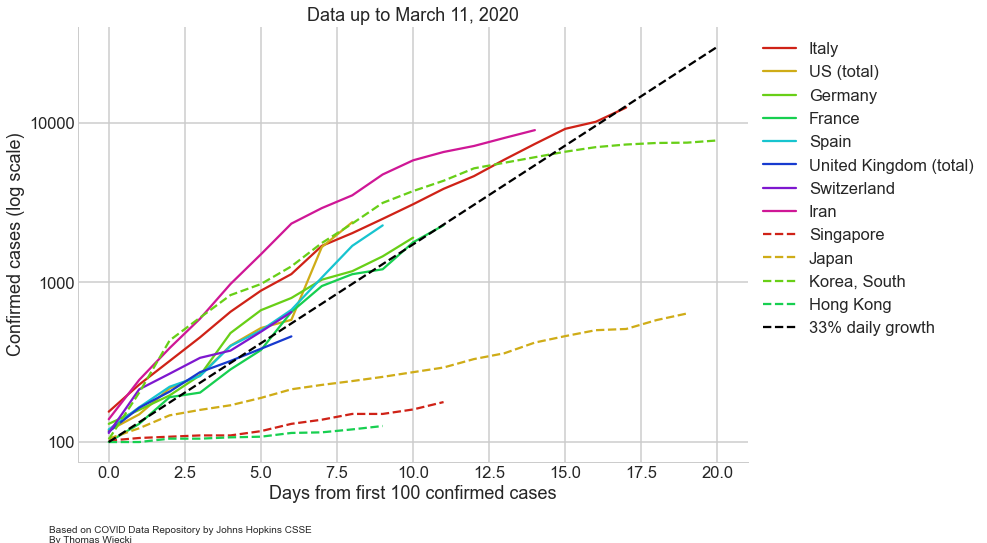

In [346]:
sns.set_palette(sns.hls_palette(8, l=.45, s=.8)) # 8 countries max
fig, ax = plt.subplots(figsize=(12, 8))

countries = ['Italy', 'US (total)', 'Germany', 'France', 'Spain', 'United Kingdom (total)', 
             'Switzerland', 'Iran']
plot_confirmed(countries)

asian_countries = ['Singapore', 'Japan', 'Korea, South', 'Hong Kong'] 
plot_confirmed(asian_countries, ls='--')


x = np.linspace(0, plt.xlim()[1] - 1)
plt.plot(x, 100 * (1.33) ** x, ls='--', color='k', label='33% daily growth')

plt.yscale('log');
plt.title('Data up to {}'.format(df.index.max().strftime('%B %d, %Y')))
plt.xlabel('Days from first 100 confirmed cases')
plt.ylabel('Confirmed cases (log scale)')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.legend(bbox_to_anchor=(1.0, 1.0))
sns.despine()
plt.annotate('Based on COVID Data Repository by Johns Hopkins CSSE\nBy Thomas Wiecki', 
             (0.05, 0.0), xycoords='figure fraction', fontsize=10);

## License (BSD-3-Clause)

Copyright 2020, Thomas Wiecki

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its contributors may be used to endorse or promote products derived from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.